In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm

from utils import *
from methods import *
from plotting_functions import *

from models import *


def plot(model, stats, pos):
    bestphase = np.argmin(stats['loss'])
    p0 = model.unit_cell.wrap(np.array(stats['phases'][0]) )
    p1 = model.unit_cell.wrap(np.array(stats['phases'][bestphase]))
    xyweights = stats['weights'][bestphase]
    # Plot current best phases
    
    fig = plt.figure(figsize = (10,5), dpi = 120)
    ax0 = fig.add_subplot(121)
    ax0.scatter(*p0.T)
    ax0.set_title('Initial phases')
    ax1 = fig.add_subplot(122)
    ax1.scatter(*p1.T)
    ax1.set_title('Best phases')
    [ax.axis('equal') for ax in [ax0,ax1]]
    [model.unit_cell.plot(fig,ax) for ax in [ax0,ax1]]

    pos *= model.pos_scale 
    activity = model(pos)
    decode_pos = torch.matmul(activity, xyweights)
    # Plot positions
    fig, ax = plt.subplots(1,2)
    if model.hex_metric:                        
        diffall = torch.zeros(7, len(pos))
        for i in range(7):
            diffall[i] = torch.sum(torch.square((decode_pos+model.addition[i]) - pos),1)
        err = torch.min(diffall,0).values
        decode_pos = model.unit_cell.wrap(decode_pos.detach().numpy())
    else:
        err = torch.sum(torch.square(decode_pos - pos),1)
        decode_pos = decode_pos.detach().numpy()
    err = err.detach().numpy()
    

    vals = np.unique(err)
    model.unit_cell.plot(fig,ax[0])
    ax[0].scatter(*pos.T, c = err, s = 250, vmin = vals[int(0.01*len(err))], vmax = vals[int(0.99*len(err))])
    ax[0].set_aspect('equal', 'box')
    ax[0].set_title('Sampled pos')
    model.unit_cell.plot(fig,ax[1])
    ax[1].scatter(*decode_pos.T, c = err, s = 250, vmin = vals[int(0.01*len(err))], vmax = vals[int(0.99*len(err))])
    ax[1].set_aspect('equal', 'box')
    ax[1].set_title('Decoded pos')

    # Plot loss
    plt.figure(figsize = (10,5), dpi = 120)
    plt.plot(stats['loss'])
    plt.title('loss')
    plt.show()
    print('')



In [2]:

N_nrns = 6

model_rand = HexagonalGCs(ncells=N_nrns)

model_CI = Similitude(ncells=N_nrns,lr=1e-3)

model_RCI = JitterCI(ncells=N_nrns, dropout=False,lr=1e-3,
                        p_magnitude=1e-1,r_magnitude=1e-1)

model_HOM = Homology(ncells=N_nrns,lr=1e-3)



  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\Finnern\AppData\Local\Temp/ipykernel_10608/639448699.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stats['phases'].append(torch.tensor(model_LIN.phases))
C:\Users\Finnern\AppData\Local\Temp/ipykernel_10608/639448699.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stats['weights'].append(torch.tensor(model_LIN.xyweights))
 50%|███████████████████████████████████████▍                                       | 499/1000 [01:41<01:45,  4.76it/s]

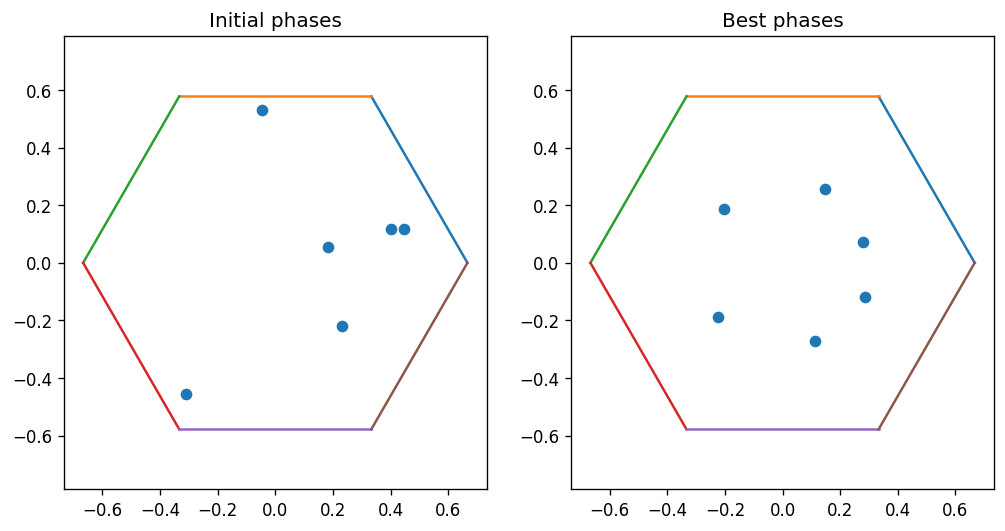

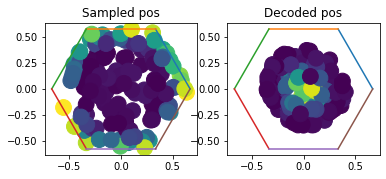

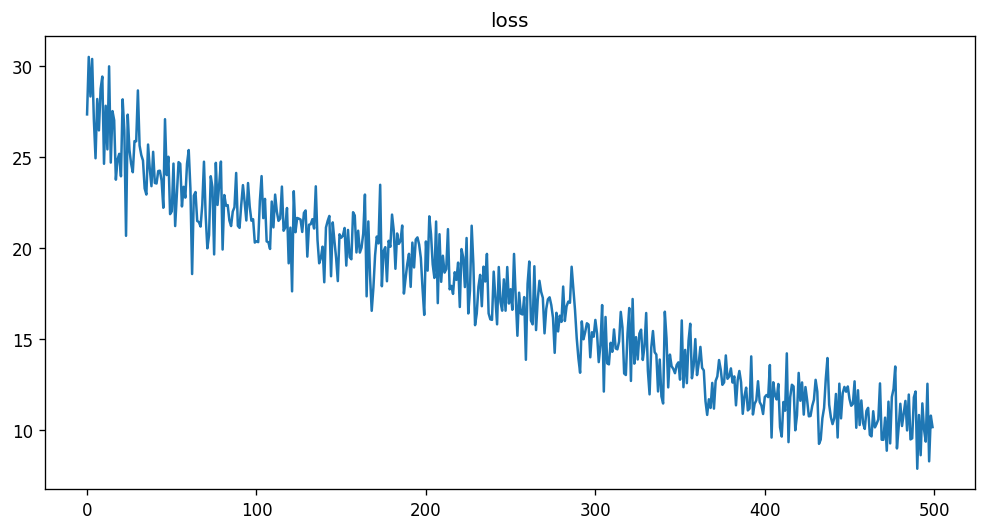

 50%|███████████████████████████████████████▌                                       | 501/1000 [01:43<04:40,  1.78it/s]


min=7.88 and mincurr=7.88


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [03:39<00:00,  3.77it/s]

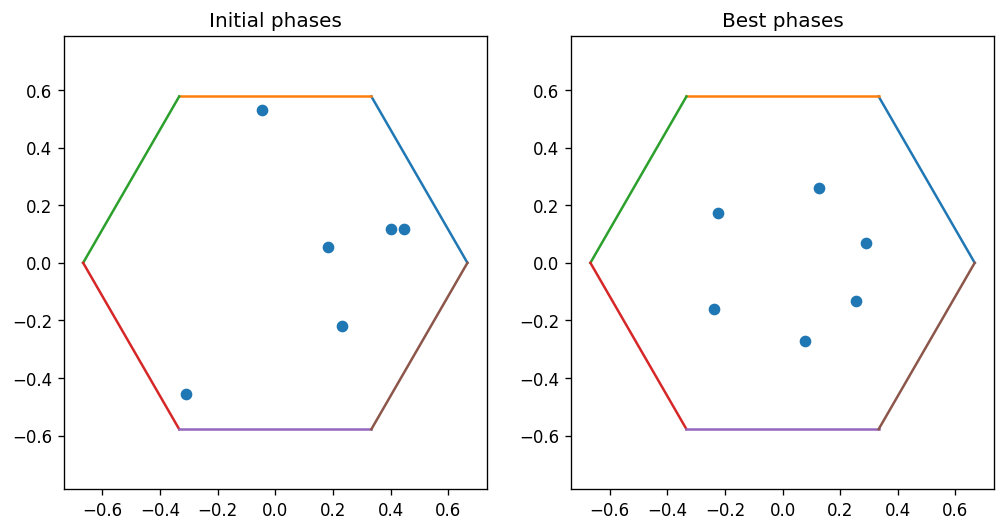

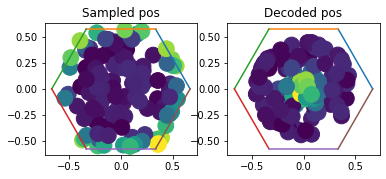

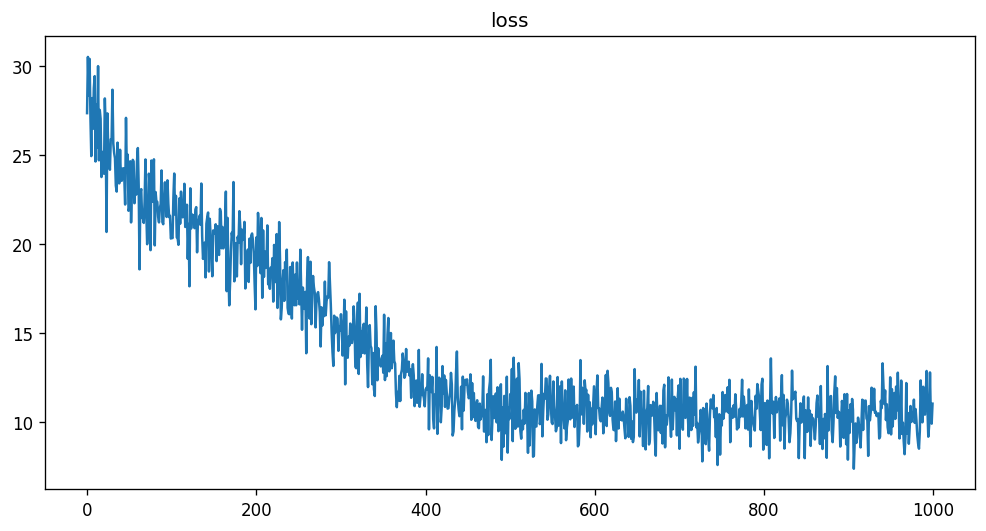

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:42<00:00,  4.50it/s]


min=7.38 and mincurr=7.38


In [3]:
start_phases = torch.normal(torch.zeros((N_nrns,2))+0.2,0.25)
model_rand.set_phases(start_phases)
model_CI.set_phases(start_phases)
model_RCI.set_phases(start_phases)
model_HOM.set_phases(start_phases)
nsamples_space = 2**7
loss_history_CI, loss_history_RCI, loss_history_HOM = [], [], []

model_LIN = LinDecoder(ncells = N_nrns,)
model_LIN.set_phases(start_phases)
loss_history_LIN = []

stats = {}
stats['loss'] = []
stats['phases'] = []
stats['weights'] = []

bPlot = True
train_steps = 500
for epoch in tqdm.trange(1000):
    rs = model_CI.unit_cell.sample(nsamples_space)
    rs = torch.tensor(rs,dtype=torch.float32)
    loss_CI = model_CI.train_step(rs)
    loss_RCI = model_RCI.train_step(rs)
    loss_HOM = model_HOM.train_step(rs)
    loss_history_CI.append(loss_CI)
    loss_history_RCI.append(loss_RCI)
    loss_history_HOM.append(loss_HOM)
    loss_LIN = model_LIN.train_step(rs)
    stats['loss'].append(loss_LIN)
    stats['phases'].append(torch.tensor(model_LIN.phases))              
    stats['weights'].append(torch.tensor(model_LIN.xyweights))              

    # print stuff
    if not ((epoch+1) % train_steps):
        if bPlot:
            plot(model_LIN, stats, rs)
        mincurr = np.min(stats['loss'])
        mincurrtrain = np.min(stats['loss'][-train_steps:]) 
        log = 'min=%.2f and mincurr=%.2f' % (mincurr, mincurrtrain)
        print(log)

loss_history_LIN = stats['loss']

(-5.0, 30.0)

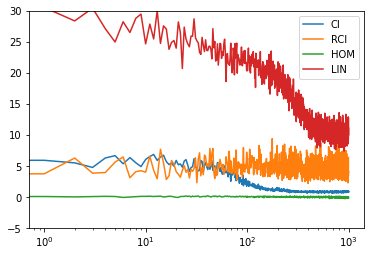

In [4]:
plt.plot(loss_history_CI)
plt.plot(loss_history_RCI)
plt.plot(loss_history_HOM)
plt.plot(loss_history_LIN)
plt.legend(['CI','RCI','HOM', 'LIN'])
plt.xscale('log')
#plt.xlim(100,2000)
plt.ylim(-5,30)

In [5]:
#evaluate metrics 
metrics = [model_CI.loss_fn, model_RCI.loss_fn, model_HOM.loss_fn, model_LIN.loss_fn2 ]
models = [model_rand, model_CI, model_RCI, model_HOM, model_LIN]
model_types = [Similitude(ncells=N_nrns), 
               JitterCI(ncells=N_nrns, p_magnitude=1e-1,r_magnitude=1e-1), 
               Homology(ncells=N_nrns), 
               LinDecoder(ncells = N_nrns,least_squares = True)]
n_perms = 10

model_hmap = np.zeros([len(models),len(metrics),n_perms])

for n in range(n_perms):
    rs = model_RCI.unit_cell.sample(nsamples_space)
    rs = torch.tensor(rs,dtype=torch.float32)
    for count1, mtric in enumerate(model_types):
        for count2, mod in enumerate(models):
            temp_model = model_types[count1]
            temp_model.set_phases(mod.phases)
            model_hmap[count2,count1,n] = temp_model.loss_fn(rs)

hmap_std = np.std(model_hmap,2)
model_hmap = np.mean(model_hmap,2)

([<matplotlib.axis.YTick at 0x1e532697ca0>,
 [Text(0, 0, 'random'),
  Text(0, 1, 'CI'),
  Text(0, 2, 'RCI'),
  Text(0, 3, 'HOM'),
  Text(0, 4, 'LIN')])

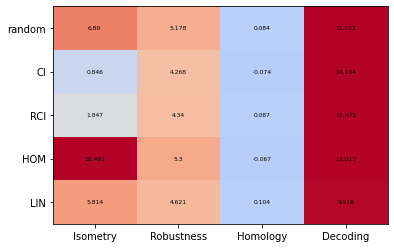

In [6]:
annotate_imshow(model_hmap,round_val=3,cmap='coolwarm',vmin=-6,vmax=10)
plt.xticks([0,1,2,3],['Isometry','Robustness','Homology', 'Decoding'])
plt.yticks([0,1,2,3,4],['random','CI','RCI','HOM', 'LIN'])


Text(0.5, 1.0, 'Standard deviation')

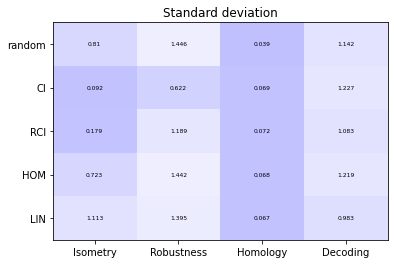

In [7]:
annotate_imshow(hmap_std,round_val=3,cmap='bwr',vmin=-6,vmax=10)
plt.xticks([0,1,2,3],['Isometry','Robustness','Homology', 'Decoding'])
plt.yticks([0,1,2,3,4],['random','CI','RCI','HOM', 'LIN'])
plt.title('Standard deviation')